# Dfsu - Export to netcdf
* Read data from dfsu file
* Convert to xarray dataset
* Write to netcdf file

In [1]:
# pip install mikeio xarray netcdf4

In [2]:
import os
import xarray as xr

In [3]:
from mikeio import Dfsu

In [4]:
filename = "../tests/testdata/oresund_sigma_z.dfsu"
dfsu = Dfsu(filename)
dfsu

Dfsu3DSigmaZ
Number of elements: 17118
Number of nodes: 12042
Projection: UTM-33
Number of sigma layers: 4
Max number of z layers: 5
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)
Time: 3 steps with dt=10800.0s
      1997-09-15 21:00:00 -- 1997-09-16 03:00:00

In [5]:
nc = dfsu.node_coordinates
xn = nc[:,0]
yn = nc[:,1]
zn = nc[:,2]

ec = dfsu.element_coordinates
xe = ec[:,0]
ye = ec[:,1]
ze = ec[:,2]

In [6]:
ds = dfsu.read()
ds

<mikeio.Dataset>
Dimensions: (3, 17118)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)

In [7]:
# Time
time = ds.time

# Node based data
node_ids = dfsu.node_ids
z_dynamic = ds['Z coordinate'].to_numpy()
xn_da = xr.DataArray(xn, coords=[node_ids], dims=["nodes"], attrs={'units': 'meter'})
yn_da = xr.DataArray(xn, coords=[node_ids], dims=["nodes"], attrs={'units': 'meter'})
zn_da = xr.DataArray(zn, coords=[node_ids], dims=["nodes"], attrs={'units': 'meter'})
z_dyn_da = xr.DataArray(z_dynamic, coords =[time,node_ids],dims=["time", "nodes"], attrs={'units': 'meter'})

# Element based data
el_ids = dfsu.element_ids
xe_da = xr.DataArray(xe, coords=[el_ids], dims=["elements"], attrs={'units': 'meter'})
ye_da = xr.DataArray(ye, coords=[el_ids], dims=["elements"], attrs={'units': 'meter'})
ze_da = xr.DataArray(ze, coords=[el_ids], dims=["elements"], attrs={'units': 'meter'})

In [8]:
# Add coordinates for nodes and elements
data_dict = {'x': xn_da,
             'y' :yn_da,
             'z' : zn_da,
             'xe' : xe_da,
             'ye' : ye_da,
             'ze' : ze_da,
             'z_dynamic' : z_dyn_da}

# add rest of data
for key, value in ds.data_vars.items():
    # skip Z coordinate since this is defined on nodes

    if key != "Z coordinate":
        da = xr.DataArray(value.to_numpy(), 
                          coords = [time,el_ids],
                          dims=["time", "elements"],
                          attrs={'units': value.unit.name})

        data_dict[key] = da


# Here are some examples of global attributes, which is useful, but in most cases not required
attributes={'title:' : dfsu._source.FileTitle,
            'history': os.path.basename(filename),
            'source': 'Mike 3 FM - Oresund',
            'instituion': 'DHI'}

# create an xarray dataset
xr_ds = xr.Dataset(data_dict, attrs=attributes)

In [17]:
ds.Temperature

<mikeio.DataArray>
Name: Temperature
Dimensions: (3, 17118)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00

In [18]:
ds.Salinity

<mikeio.DataArray>
Name: Salinity
Dimensions: (3, 17118)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00

<AxesSubplot:xlabel='time', ylabel='Salinity [PSU]'>

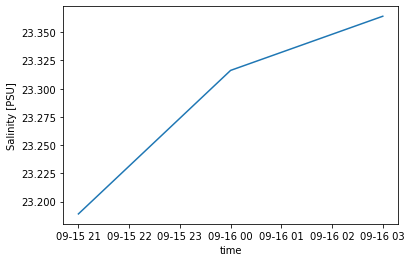

In [11]:
ds.Salinity[:,0].plot()

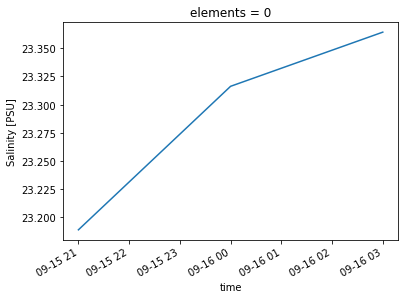

In [12]:
xr_ds.Salinity[:,0].plot()

In [13]:
xr_ds.to_netcdf("oresund_sigma_z.nc")

# Clean up

In [14]:
import os
os.remove("oresund_sigma_z.nc")